In [ ]:
!python --version
!wget http://geneontology.org/gene-associations/gene_association.sgd.gz -O ./data/gene_association.sgd.gz
!wget http://purl.obolibrary.org/obo/go.obo -O ./data/go.obo
!wget http://chianti.ucsd.edu/\~kono/ci/data/deep-cell/raw-interactions_clixo_intTable_kei_pm_ranks.txt -O ./data/interaction-table-atgo.txt

# From YeastNet to CLIXO term documents

## What's this?

This notebook is for building Elasticsearch index for CLIXO ontology.

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from goatools import obo_parser

# Annotation file for the CLIXO terms
clixo_mapping = './data/alignments_FDR_0.1_t_0.1'
oboUrl = './data/go.obo'

clixo_align = pd.read_csv(clixo_mapping, sep='\t', names=['term', 'go', 'score', 'fdr', 'genes'])
print(clixo_align['score'].max())
clixo_align.tail(10)

0.919767


,term,go,score,fdr,genes
1816,10275,GO:0043173,0.100885,0.008403,17
1817,10130,GO:0023052,0.100796,0.050699,12
1818,10417,GO:0031985,0.100767,0.008414,26
1819,10330,GO:0005816,0.100752,0.008356,20
1820,10402,GO:1901475,0.100737,0.008299,25
1821,10348,GO:0004551,0.100707,0.008311,21
1822,10303,GO:0060962,0.100455,0.008523,18
1823,10552,GO:0098772,0.100313,0.037656,55
1824,9932,GO:0015720,0.100272,0.053004,9
1825,9887,GO:0015292,0.100264,0.052883,9


## Load raw interaction table originally created for AtgO

This table was created for AtgO, but can be used this, too.


In [3]:
clixo2go = {}
for row in clixo_align.itertuples():
    c = str(row[1])
    go = row[2]
    val = {
        'go': go,
        'score': row[3].item(),
        'fdr': row[4].item(),
        'genes': row[5].item()
    }
    clixo2go[c] = val

print(clixo2go['10552'])

# Save to file (for updating CyJS file)
import json
with open('./data/clixo-mapping.json', 'w') as outfile:
    json.dump(clixo2go, outfile)

{'go': 'GO:0098772', 'score': 0.100313, 'genes': 55, 'fdr': 0.037656300000000004}


In [4]:
obo = obo_parser.GODag(oboUrl, optional_attrs=['def'])

load obo file ./data/go.obo
./data/go.obo: fmt(1.2) rel(2017-01-16) 47,969 GO Terms


In [5]:
# test data
obo['GO:0006563'].defn

'"The chemical reactions and pathways involving L-serine, the L-enantiomer of serine, i.e. (2S)-2-amino-3-hydroxypropanoic acid." [CHEBI:17115, GOC:ai, GOC:jsg]'

In [6]:
# This directory should contains all of the YeastNet interaction files
# data_path = './data/raw-interactions'
# files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
# files

## Create single interaction DataFrame

From all interaction fiules, make a table with all interactions

In [7]:
# columns = ['source', 'target', 'score']
# all_interactions = pd.DataFrame(columns=columns)

# for f in files:
#     if not f.startswith('INT'):
#         continue
    
#     int_type = f.split('.')[1]
#     df = pd.read_csv(data_path+'/'+ f, delimiter='\t', names=columns)
#     df['interaction'] = int_type
#     all_interactions = pd.concat([all_interactions, df])

# print(all_interactions.shape)
# all_interactions.head(10)

In [8]:
# all_interactions.to_csv('./data/raw-interactions/all.txt', sep='\t')

## Create list of all genes associated with CLIXO terms

In [9]:
# CLIXO term to gene mapping
mapping = pd.read_csv('./data/raw-interactions/preds_yeastnet_no_gi_0.04_0.5.txt.propagate.mapping', delimiter='\t', names=['gene', 'term'])
mapping.head()

,gene,term
0,YGR220C,10000
1,YPR100W,10000
2,YNR022C,10000
3,YNL252C,10000
4,YCR046C,10000


In [10]:
mapping['term'].unique().shape # Number of terms

(4805,)

In [11]:
# All ORF names in CLIXO
mixed_ids = mapping['gene'].unique()
print(mixed_ids.shape)

geneset = set()

for row in mapping.itertuples():
    geneset.add(row[1])
    
print(len(geneset))

(5886,)
5886


### Standardize the gene IDs to SGD

In [12]:
# Import gene association file
yeastAnnotationUrl = './data/gene_association.sgd.gz'
cols = pd.read_csv('./annotation_columns.txt', names=['col_names'])
col_names = cols['col_names'].tolist()
yeastAnnotation = pd.read_csv(yeastAnnotationUrl, delimiter='\t', comment='!', compression='gzip', names=col_names)
yeastAnnotation.tail()

,DB,DB_Object_ID,DB_Object_Symbol,Qualifier,GO_ID,DB:Reference,Evidence,With_or_From,Aspect,DB_Object_Name,DB_Object_Synonym,DB_Object_Type,taxon,Date,Assigned_by,Annotation_Extension,Gene_Product_Form_ID
111384,SGD,S000006732,tX(XXX)L,NaN,GO:0030533,SGD_REF:S000181097|PMID:9023104,ISM,NaN,F,"tRNA of undetermined specificity, predicted by...",tX(XXX)L|tS(GCU)L,gene,taxon:559292,20030507,SGD,NaN,NaN
111385,SGD,S000006732,tX(XXX)L,NaN,GO:0005829,SGD_REF:S000181097|PMID:9023104,IC,GO:0030533,C,"tRNA of undetermined specificity, predicted by...",tX(XXX)L|tS(GCU)L,gene,taxon:559292,20030507,SGD,NaN,NaN
111386,SGD,S000007338,tY(GUA)Q,NaN,GO:0070125,SGD_REF:S000181097|PMID:9023104,IC,GO:0030533,P,Mitochondrial tyrosine tRNA (tRNA-Tyr),tY(GUA)Q,gene,taxon:559292,20150730,SGD,NaN,NaN
111387,SGD,S000007338,tY(GUA)Q,NaN,GO:0005739,SGD_REF:S000181097|PMID:9023104,IC,GO:0030533,C,Mitochondrial tyrosine tRNA (tRNA-Tyr),tY(GUA)Q,gene,taxon:559292,20030507,SGD,NaN,NaN
111388,SGD,S000007338,tY(GUA)Q,NaN,GO:0030533,SGD_REF:S000181097|PMID:9023104,ISM,NaN,F,Mitochondrial tyrosine tRNA (tRNA-Tyr),tY(GUA)Q,gene,taxon:559292,20060721,SGD,NaN,NaN


In [13]:
# Mapping object: from any type of ID to SGD ID
to_sgd = {}

# Annotation for genes
sgd2fullname = {}
sgd2symbol = {}

for row in yeastAnnotation.itertuples():
    sgd = row[2]
    orf = row[3]
    full_name = str(row[10]).replace('\r\n', '')
    syn = str(row[11])
    syns = syn.split('|')
    to_sgd[orf] = sgd
    for synonym in syns:
        to_sgd[synonym] = sgd
    sgd2fullname[sgd] = full_name
    sgd2symbol[sgd] = orf
    
# Special case
to_sgd['AAD16'] = 'S000001837' 

# Make sure all genes in the interaction table exists in the mapping table

In [14]:
normalized_map = []

for row in mapping.itertuples():
    gene = row[1]
    term = str(row[2])
    
    # Convert to SGD
    sgd = gene
    if gene in to_sgd.keys():
        sgd = to_sgd[gene]
    entry = (sgd, term)
    normalized_map.append(entry)

In [15]:
# All ORF to SGD
all_sgd = list(map(lambda x: to_sgd[x] if x in to_sgd.keys() else x, mixed_ids))
if len(all_sgd) == len(mixed_ids):
    print('All mapped!')
    
# This contains all gene IDs (SGD ID)
uniq_genes = set(all_sgd)
len(uniq_genes)

All mapped!


5872

In [16]:
geneset_sgd = set()

for gene in geneset:
    if gene not in to_sgd.keys():
        geneset_sgd.add(gene)
    else:
        geneset_sgd.add(to_sgd[gene])
        
len(geneset_sgd)

5872

In [17]:
df_genes = pd.DataFrame(list(uniq_genes))

# Save as text file and use it in UNIPROT ID Mapper
df_genes.to_csv('./data/all_sgd.txt', sep='\t', index=False, header=False)

In [18]:
uniprot = pd.read_csv('./data/uniprot-idmapping.txt', delimiter='\t')
print(uniprot.shape)
uniprot.head()

(5874, 13)


,Entry,yourlist:M20170106AAFB7E4D2F1D05654627429E83DA5CCE9FB1772,Entry name,Status,Protein names,Gene names,Organism,Length,Gene names (primary ),Gene names (synonym ),Gene names (ordered locus ),Gene names (ORF ),Pathway
0,P11914,S000001066,MPPA_YEAST,reviewed,Mitochondrial-processing peptidase subunit alp...,MAS2 MIF2 YHR024C,Saccharomyces cerevisiae (strain ATCC 204508 /...,482,MAS2,MIF2,YHR024C,NaN,NaN
1,Q3E7Z2,S000028850,YN042_YEAST,reviewed,Uncharacterized protein YNL042W-B,YNL042W-B,Saccharomyces cerevisiae (strain ATCC 204508 /...,85,NaN,NaN,YNL042W-B,NaN,NaN
2,P49956,S000004683,CTF18_YEAST,reviewed,Chromosome transmission fidelity protein 18,CTF18 CHL12 YMR078C YM9582.03C,Saccharomyces cerevisiae (strain ATCC 204508 /...,741,CTF18,CHL12,YMR078C,YM9582.03C,NaN
3,P38890,S000001250,SET5_YEAST,reviewed,Putative protein lysine methyltransferase SET5...,SET5 YHR207C,Saccharomyces cerevisiae (strain ATCC 204508 /...,526,SET5,NaN,YHR207C,NaN,NaN
4,Q01852,S000001284,TIM44_YEAST,reviewed,Mitochondrial import inner membrane translocas...,TIM44 ISP45 MIM44 MPI1 YIL022W,Saccharomyces cerevisiae (strain ATCC 204508 /...,431,TIM44,ISP45 MIM44 MPI1,YIL022W,NaN,NaN


In [19]:
sgd2orf = {}
for row in uniprot.itertuples():
    sgd = row[2]
    orf = row[11]
    sgd2orf[sgd] = orf

# Test
missing = set()
for sgd in uniq_genes:
    if sgd not in sgd2orf.keys():
        missing.add(sgd)

print(len(missing))
print(missing)

10
{'S000000214', 'S000006284', 'S000005659', 'S000000322', 'S000004975', 'S000001767', 'S000002793', 'S000000213', 'S000004976', 'S000003674'}


In [20]:
idmap = pd.read_csv('./yeast_clean4.txt', delimiter='\t')
idmap.head()

,symbol,locus_name,acc_number,swiss-prot,sgd,sequence_length,3d,chromosome
0,AAC1,YMR056C,P04710,ADT1_YEAST,S000004660,309,13,NaN
1,AAC3,YBR085W,P18238,ADT3_YEAST,S000000289,307,(3),2
2,AAD10,YJR155W,P47182,AAD10_YEAST,S000003916,288,10,NaN
3,AAD14,YNL331C,P42884,AAD14_YEAST,S000005275,376,14,NaN
4,AAD15,YOL165C,Q08361,AAD15_YEAST,S000005525,143,15,NaN


In [21]:
sgd2orf2 = {}
for row in idmap.itertuples():
    sgd = row[5]
    orf = row[2]
    sgd2orf2[sgd] = orf

for sgd in missing:
    sgd2orf[sgd] = sgd2orf2[sgd]

# Test
missing = set()
for sgd in uniq_genes:
    if sgd not in sgd2orf.keys():
        missing.add(sgd)

print(len(missing))
print(len(sgd2orf))

0
5877


## Create mapping from gene to interactions

In [22]:
gene_map = {}
missing_count = 0

all_orf = set(sgd2orf.values())
len(all_orf)

5877

In [23]:
all_interactions = pd.read_csv('./data/interaction-table-atgo.txt',  sep="\t")
all_interactions.head()

,INT1,INT2,Co-expression,Protein-protein interactions (high-throughput),Domain co-occurrence,Genomic context,Phylogenetic similarity,Predicted from 3D structure,Protein-protein interactions (low-throughput),Co-citation,Co-expression.1,Protein-protein interactions (high-throughput).1,Domain co-occurrence.1,Genomic context.1,Phylogenetic similarity.1,Predicted from 3D structure.1,Protein-protein interactions (low-throughput).1,Co-citation.1
0,YHR213W,YAR029W,0.202,0.0,0.000,0.0,0.0,0.0,0.0,0.0,Stanford Microarray Database DNA Damage,0,0,0,0,0,0,0
1,YHR213W,YCR007C,0.179,0.0,0.000,0.0,0.0,0.0,0.0,0.0,Stanford Microarray Database YPDstat,0,0,0,0,0,0,0
2,YHR213W,YFL051C,0.000,0.0,0.844,0.0,0.0,0.0,0.0,0.0,0,0,24165882,0,0,0,0,0
3,YHR213W,TDA8,0.000,0.0,0.844,0.0,0.0,0.0,0.0,0.0,0,0,24165882,0,0,0,0,0
4,YHR213W,YAL064W-B,0.683,0.0,0.000,0.0,0.0,0.0,0.0,0.0,Stanford Microarray Database YPDstat,0,0,0,0,0,0,0


In [24]:
## Filter edges

print('All interaction count: ' + str(all_interactions.shape))

filtered = []
# Filter
for row in all_interactions.itertuples():
    if row[1] not in to_sgd.keys():
        to_sgd[row[1]] = row[1]
    if row[2] not in to_sgd.keys():
        to_sgd[row[2]] = row[2]

All interaction count: (1360234, 18)


In [25]:
term2gene = {}

for row in mapping.itertuples():
    term = str(row[2])
    
    gene = ''
    if row[1] not in to_sgd.keys():
        gene = row[1]
        to_sgd[gene] = gene
    else:
        gene = to_sgd[row[1]]
    
    assigned = set()
    
    if term in term2gene.keys():
        assigned = term2gene[term]
    
    assigned.add(gene)
    term2gene[term] = assigned

print(len(term2gene))
print(term2gene['10000'])

4805
{'S000004950', 'S000000642', 'S000002645', 'S000002730', 'S000003452', 'S000004487', 'S000006304', 'S000002870', 'S000005196', 'S000005305'}


In [26]:
original_cols = all_interactions.columns
original_names = original_cols[3:10].tolist()
col_names = [ 'source', 'target', 'interaction', 'score', 'reference',]

print(original_names)

['Protein-protein interactions (high-throughput)', 'Domain co-occurrence', 'Genomic context', 'Phylogenetic similarity', 'Predicted from 3D structure', 'Protein-protein interactions (low-throughput)', 'Co-citation']


In [31]:
network = []

for row in all_interactions.itertuples():
    for idx, col in enumerate(row):
        if idx < 3 or idx > 9:
            continue
        else:
            score  = col.item()
            if score == 0:
                continue
            
            interaction = original_names[idx-3]
            pub = str(row[idx+8])
            new_row = (to_sgd[row[1]], to_sgd[row[2]], interaction, score, pub)
            network.append(new_row)


In [32]:
net_df = pd.DataFrame(network, columns=col_names)
net_df.head()

,source,target,interaction,score,reference
0,S000001256,S000000077,Protein-protein interactions (high-throughput),0.202,Stanford Microarray Database DNA Damage
1,S000001256,S000000600,Protein-protein interactions (high-throughput),0.179,Stanford Microarray Database YPDstat
2,S000001256,S000001843,Genomic context,0.844,24165882
3,S000001256,S000002140,Genomic context,0.844,24165882
4,S000001256,S000002141,Protein-protein interactions (high-throughput),0.683,Stanford Microarray Database YPDstat


In [53]:
print(net_df['score'].max())
print(net_df['score'].min())

1.0
0.001


In [35]:
net_df.to_csv('./data/clixo-raw-interactions.txt', sep='\t', encoding='utf-8', index=False)

In [36]:
# Create graph
import networkx as nx

g = nx.from_pandas_dataframe(net_df, source='source', target='target', edge_attr=['interaction', 'score', 'reference'])

['S000004747', 'S000002744', 'S000000901', 'S000005336', 'S000004484', 'S000003894', 'S000004607', 'S000000808', 'S000004703', 'S000001003', 'S000000019', 'S000005422', 'S000000164', 'S000003442', 'S000002849', 'S000001099', 'S000003067']


('S000004747', 'S000000901')

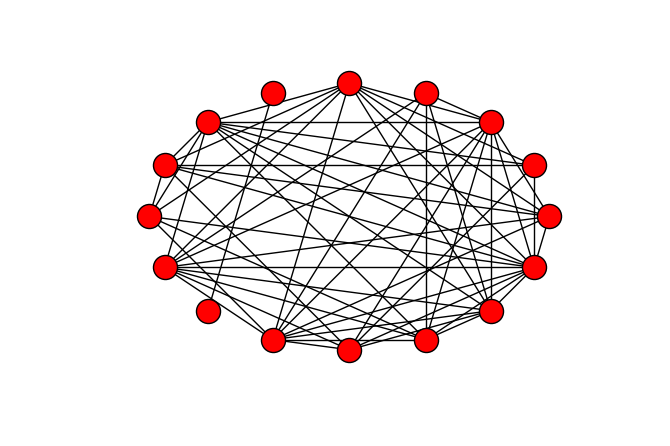

In [37]:
g.nodes()[10]
print(list(term2gene['10275']))

sub = g.subgraph(list(term2gene['10275']))

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

nx.draw_circular(sub)
sub.edges()[1]

In [38]:
term2interaction = {}

for term in term2gene.keys():
    gset = term2gene[term]
    assigned_itrs = []
    
    glist = list(gset)
    sub = g.subgraph(glist)
    
    edges = sub.edges(data=True)
    
    itrs = []
    if len(edges) > 8000:
        term2interaction[term] = itrs
        continue
        
    for e in edges:
        data = {
            'source': e[0],
            'target': e[1],
            'interaction': e[2]['interaction'],
            'score': e[2]['score']
        }
        itrs.append(data)
    
    term2interaction[term] = itrs


In [39]:
counts = []
for key in term2interaction.keys():
    counts.append(len(term2interaction[key]))

max(counts)

7305

In [47]:
clixo_genes = {}

missing_name = set()

print(len(normalized_map))

for row in normalized_map:
    sgd = row[0]
    term = str(row[1])
        
    orf = sgd2orf[sgd]
    name = orf
    symbol = ''
    
    if sgd not in sgd2fullname.keys():
        missing_name.add(sgd2orf[sgd])
        name = orf
        symbol = orf
    else:
        orf = sgd2orf[sgd]
        name = sgd2fullname[sgd]
        symbol = sgd2symbol[sgd]
        
    entry = {
        'sgdid': sgd,
        'orf': orf,
        'name': name,
        'symbol': symbol
    }
    
    assigned_genes = []
    if term in clixo_genes.keys():
        assigned_genes = clixo_genes[term]['genes']
    
    assigned_genes.append(entry)
    clixo_genes[term] = {
        'genes': assigned_genes
    }

print(missing_name)
print(len(clixo_genes))

129756
{'YLR466C-B', 'YJR114W', 'YAR073W', 'YDL118W', 'YLR154W-A'}
4805


In [48]:
for key in clixo_genes.keys():
        raw_interactions = []
        gene_list = clixo_genes[key]['genes']
        for gene in gene_list:
            sgd = gene['sgdid']
            if sgd in sgd2orf.keys():
                orf = sgd2orf[sgd]
                if orf in gene_map.keys():
                    raw_interactions.append(gene_map[orf])
        
        clixo_genes[key]['interactions'] = term2interaction[key]

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# pp.pprint(clixo_genes['10000'])

## Insert new documents to Elasticsearch

In [49]:
from elasticsearch import Elasticsearch
from datetime import datetime
from elasticsearch_dsl import DocType, Date, Integer, Keyword, Text, Object, Nested, Index, Double, Integer
from elasticsearch_dsl.connections import connections
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch_dsl import Search

from elasticsearch_dsl.query import MultiMatch, Match, Q


# Define a default Elasticsearch client
connections.create_connection(hosts=['localhost:9200'])

<Elasticsearch([{'port': 9200, 'host': 'localhost'}])>

In [50]:
# Class which represents a CLIXO term

class ClixoTerm(DocType):
    termid = Text(index='not_analyzed')
    name = Text(analyzer='standard')
    go = Object()
    gene_count = Integer(index='not_analyzed')

    genes = Object(multi=True)
    interactions=Object(multi=True)
    
    class Meta:
        index = 'terms'

def get_clixo_term(key, term):
    
    term_id = 'CLIXO:' + key

    name = term_id
    
    go = {
        'goid': 'N/A',
        'name': 'N/A',
        'definition': 'N/A',
    }
    
    gene_count = 0
    
    if key in clixo2go.keys():
        
        
        go_alignment = clixo2go[key]
        goid = go_alignment['go']
        
        if goid == 'GO:00SUPER':
            return ClixoTerm(
                meta={'id':  term_id},
                termid=term_id,
                name=name,
                go=go,
                gene_count = gene_count,

                genes=term['genes'],
                interactions=term2interaction[key])
        
        
        
        def_raw = obo[goid].defn
        def_str = def_raw.split('"')[1]
        
        go['goid'] = goid
        go['score'] = go_alignment['score']
        go['fdr'] = go_alignment['fdr']
        gene_count = go_alignment['genes']
        go['name'] = obo[goid].name
        go['definition'] = def_str
        name = obo[goid].name
    
    return ClixoTerm(
        meta={'id':  term_id},
        termid=term_id,
        name=name,
        go=go,
        gene_count = gene_count,
        
        genes=term['genes'],
        interactions=term2interaction[key]
)

In [51]:
print('init start==================')

ClixoTerm.init()

print('Init done ==================')

es = Elasticsearch(host='localhost', port=9200)
pool = []

print('Add start==================')

for id in clixo_genes.keys():
    
    d = get_clixo_term(id, clixo_genes[id])
    
    term = {'_index': getattr(d.meta, 'index', d._doc_type.index), '_type': d._doc_type.name,  '_id': d.termid, '_source': d.to_dict()}
    pool.append(term)
    if len(pool) > 500:
        print('Bulk add start:')
        helpers.bulk(es, pool)
        print('Bulk add success!')

        pool = []

if len(pool) > 0:
    print('Last: ' + str(len(pool)))
    helpers.bulk(es, pool)
    print('---------------success!')

init start==================
Init done ==================
Add start==================
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Bulk add start:
Bulk add success!
Last: 296
---------------success!
